<a href="https://colab.research.google.com/github/gjurcin/regression_RNN_LSTM_GRU/blob/main/RNN_Airline_passenger_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNNs and LSTMs

The problem to solve is Airline Passengers prediction - regression (time series).

Given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations

Link to the dataset: https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, LSTM, SimpleRNN, Input,RepeatVector

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#to be executed only once
#upload data to google coolab
from google.colab import files
uploaded = files.upload() 

Saving airline-passengers.csv to airline-passengers.csv


In [ ]:
#import it to google coolab
dataframe = pd.read_csv('/content/airline-passengers.csv')
dataframe 

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


## Dataset

In [ ]:
#reformat the dataframe to plot it as a date-time timeseries
dataframe.Month  = pd.to_datetime(dataframe.Month, format='%Y-%m')
dataframe.Passengers  = dataframe.Passengers.astype('float')
dataframe = dataframe.set_index('Month') 
dataframe

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


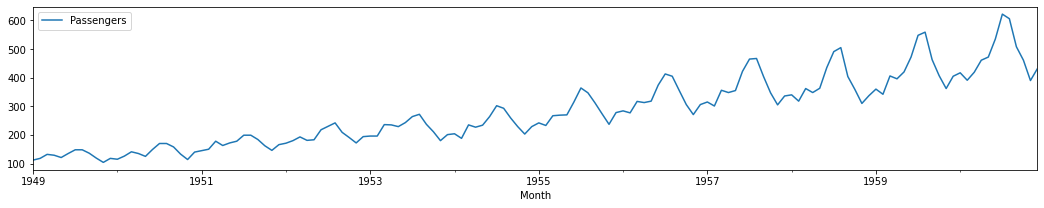

In [ ]:
dataframe.plot(figsize=(18, 3))
plt.show()

In [ ]:
# prepare the data for deep learning
sequence = dataframe.Passengers.values
sequence.shape, sequence

((144,),
 array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
        114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
        162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
        209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
        272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
        302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
        315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
        318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
        348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
        362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
        342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
        417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
        432.]))

RNNs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
It usually good to rescale the data to the range of 0-to-1 (normalization). 

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
sequence = scaler.fit_transform(sequence.reshape(-1, 1))
sequence.shape

(144, 1)

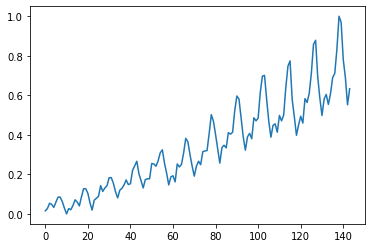

In [ ]:
plt.plot(sequence)
plt.show()

In [ ]:
# split into train and test sets. Use first 70% of the data as trianing and last 30% as test
train_size = int(len(sequence) * 0.7)
test_size = len(sequence) - train_size
train, test = sequence[:train_size,:], sequence[train_size:len(sequence),:]
train.shape, test.shape

((100, 1), (44, 1))

## Function to reshape and trasnform the dataset

Define a function to create a new dataset.

n_steps (look_back) - is the number of previous time steps to use as input variables to predict the next time period — (defaulted to 1).

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape the data and print
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
for i in range(5):
	print(trainX[i], trainY[i])

[0.01544402 0.02702703 0.05405405] 0.04826254826254825
[0.02702703 0.05405405 0.04826255] 0.03281853281853281
[0.05405405 0.04826255 0.03281853] 0.05984555984555981
[0.04826255 0.03281853 0.05984556] 0.08494208494208491
[0.03281853 0.05984556 0.08494208] 0.08494208494208491


## Reshape data
Any RNN layer in Keras expects a 3D shape (samples, timesteps, features)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape (testX.shape[0], testX.shape[1], 1)
trainX.shape,testX.shape

((96, 3, 1), (40, 3, 1))

# Stacked RNN, LSTM

An RNN/LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [ ]:
# create and fit the RNN network
def two_layered_RNN(input_shape, num_neurons):
  _input = Input(shape=input_shape,dtype='float')
  x = SimpleRNN(2*num_neurons, activation='relu', input_shape=input_shape, 
                return_sequences=True, name='hidden_1')(_input)
  x = SimpleRNN(num_neurons, activation='relu', input_shape=input_shape)(x)
  output = Dense(1)(x)
  my_model = Model(inputs=[_input], outputs=[output])
  optimizer = optimizers.Adam()
  my_model.compile(optimizer=optimizer,loss='mse')
  return my_model

num_features = trainX.shape[2]
num_timestamps = trainX.shape[1]
input_shape = (num_timestamps, num_features)
model_stack =  two_layered_RNN(input_shape, num_neurons=10)
model_stack.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
hidden_1 (SimpleRNN)         (None, 3, 20)             440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 761
Trainable params: 761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#define callbacks
callback1 = ModelCheckpoint('best_model.pt', monitor='loss', save_best_only=True, mode='min', verbose=1)
callback2 = EarlyStopping(patience=20, monitor='loss', mode='min')
callback_list = [callback1, callback2]

In [ ]:
#train the model
model_stack =  two_layered_RNN(input_shape, num_neurons=10)
h = model_stack.fit(trainX, trainY, 
          epochs=20, 
          batch_size=1, #try with 10 also
          callbacks = callback_list, 
          validation_data=(testX, testY),
          verbose=0)


Epoch 00001: loss did not improve from 0.00175

Epoch 00002: loss did not improve from 0.00175

Epoch 00003: loss did not improve from 0.00175

Epoch 00004: loss did not improve from 0.00175

Epoch 00005: loss did not improve from 0.00175

Epoch 00006: loss did not improve from 0.00175

Epoch 00007: loss did not improve from 0.00175

Epoch 00008: loss did not improve from 0.00175

Epoch 00009: loss did not improve from 0.00175

Epoch 00010: loss did not improve from 0.00175

Epoch 00011: loss did not improve from 0.00175

Epoch 00012: loss did not improve from 0.00175

Epoch 00013: loss did not improve from 0.00175

Epoch 00014: loss did not improve from 0.00175

Epoch 00015: loss did not improve from 0.00175

Epoch 00016: loss did not improve from 0.00175

Epoch 00017: loss did not improve from 0.00175

Epoch 00018: loss did not improve from 0.00175

Epoch 00019: loss did not improve from 0.00175

Epoch 00020: loss did not improve from 0.00175


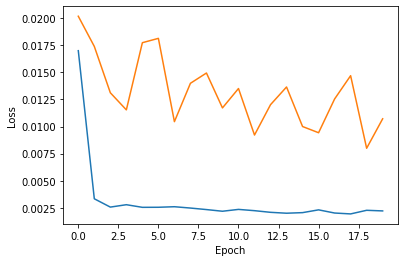

In [ ]:
#plot learning curves
plt.plot(h.history['loss'],label='train_loss')
plt.plot(h.history['val_loss'],label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
# make predictions
trainPredict = model_stack.predict(trainX)
testPredict = model_stack.predict(testX)
testPredict[:5]

array([[0.59302354],
       [0.6119746 ],
       [0.49729258],
       [0.42297068],
       [0.36754212]], dtype=float32)

In [ ]:
# invert predictions from normalzied values to real values
trainPredict_ = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])
testPredict_ = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])
testPredict_[:5]

array([[411.18622],
       [421.00287],
       [361.59756],
       [323.09882],
       [294.3868 ]], dtype=float32)

### Evaluate the model

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_[0], trainPredict_[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_[0], testPredict_[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

print('\nTrain Score: %.2f MAE' % (mean_absolute_error(trainY_[0], trainPredict_[:,0])))
print('Test Score: %.2f MAE' % (mean_absolute_error(testY_[0], testPredict_[:,0])))

Train Score: 21.57 RMSE
Test Score: 53.61 RMSE

Train Score: 17.86 MAE
Test Score: 42.87 MAE


### Visualize the predictions

In [ ]:
#visualize the predictions
dataframe['train_pred']=np.nan
dataframe['test_pred']=np.nan
dataframe.iloc[look_back:look_back+len(trainPredict_),1]= trainPredict_[:,0]
dataframe.iloc[-len(testPredict_):,2]= testPredict_[:,0]

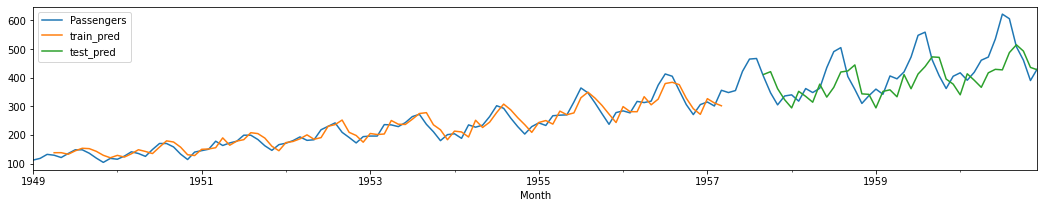

In [ ]:
dataframe.plot(figsize=(18, 3))

# Many to Many

## Prepare the data in appropriate format

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
n_features = 1
# split into samples
trainX, trainY = split_sequence(train, n_steps_in, n_steps_out)
testX, testY = split_sequence(test, n_steps_in, n_steps_out)
# summarize the data
for i in range(3):
	print(testX[i], "\n Y: "  ,testY[i])

[[0.48455598]
 [0.61389961]
 [0.6969112 ]] 
 Y:  [[0.7007722 ]
 [0.57915058]]
[[0.61389961]
 [0.6969112 ]
 [0.7007722 ]] 
 Y:  [[0.57915058]
 [0.46911197]]
[[0.6969112 ]
 [0.7007722 ]
 [0.57915058]] 
 Y:  [[0.46911197]
 [0.38803089]]


There are 2 (n_steps_out) predictions for each data point. Thus, we need to take the predicitons on each 'n_steps_out' step

In [ ]:
testY = testY[::n_steps_out]
testX = testX[::n_steps_out]
testY.shape,testX.shape,trainX.shape

((20, 2, 1), (20, 3, 1), (96, 3, 1))

## Create the model

In [ ]:
# define model
def LSTM_model_many(imput_shape,num_neurons,n_steps_out):
  _input = Input(shape=input_shape,dtype='float', name='m_input')
  x = LSTM(num_neurons, activation='relu')(_input)
  x= RepeatVector(n_steps_out)(x)
  x = LSTM(num_neurons, activation='relu', return_sequences=True)(x)
  output =Dense(1)(x)
  my_model = Model(inputs=[_input], outputs=[output])
  optimizer = optimizers.Adam()
  my_model.compile(optimizer=optimizer,loss='mse')
  return my_model
 
num_features = trainX.shape[2]
num_timestamps = trainX.shape[1]
input_shape = (num_timestamps, num_features)
num_neurons=100
model = LSTM_model_many(input_shape,num_neurons,n_steps_out)
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_input (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 100)            80400     
_________________________________________________________________
dense_7 (Dense)              (None, 2, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the mode
model = LSTM_model_many(input_shape,num_neurons,n_steps_out)
h=model.fit(trainX, trainY, epochs=100,  validation_data=(testX, testY),verbose=1)

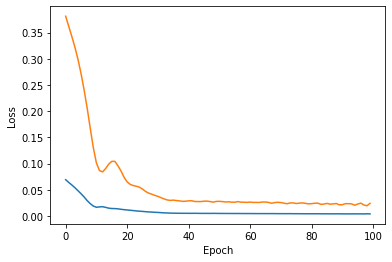

In [ ]:
# plot learning curves
plt.plot(h.history['loss'],label='train_loss')
plt.plot(h.history['val_loss'],label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Make the predictions

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

## Reshape the predictions

In [ ]:

# invert predictions from normalized values to real values for 1-step predictions
trainPredict_1 = scaler.inverse_transform(trainPredict[:,0])
trainY_1 = scaler.inverse_transform(trainY[:,0])
testPredict_1 = scaler.inverse_transform(testPredict[:,0])
testY_1 = scaler.inverse_transform(testY[:,0])


# invert predictions from normalized values to real values for 2-step predictions
trainPredict_2 = scaler.inverse_transform(trainPredict[:,1])
trainY_2 = scaler.inverse_transform(trainY[:,1])
testPredict_2 = scaler.inverse_transform(testPredict[:,1])
testY_2 = scaler.inverse_transform(testY[:,1])

## Evaluation

In [ ]:
# calculate and print evaluation metrics
trainScore = math.sqrt(mean_squared_error(trainY_1[:,0], trainPredict_1[:,0]))
print('1-step Train RMSE: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_1[:,0], testPredict_1[:,0]))
print('1-step Test RMSE: %.2f RMSE' % (testScore))

print('1-step Train MAE: %.2f MAE' % (mean_absolute_error(trainY_1[:,0], trainPredict_1[:,0])))
print('1-step Test MAE: %.2f MAE' % (mean_absolute_error(testY_1[:,0], testPredict_1[:,0])))


trainScore = math.sqrt(mean_squared_error(trainY_2[:,0], trainPredict_2[:,0]))
print('\n2-steps Train RMSE: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_2[:,0], testPredict_2[:,0]))
print('2-steps Test RMSE: %.2f RMSE' % (testScore))

print('2-steps Train MAE: %.2f MAE' % (mean_absolute_error(trainY_2[:,0], trainPredict_2[:,0])))
print('2-steps Test MAE: %.2f MAE' % (mean_absolute_error(testY_2[:,0], testPredict_2[:,0])))

1-step Train RMSE: 28.19 RMSE
1-step Test RMSE: 60.02 RMSE
1-step Train MAE: 21.98 MAE
1-step Test MAE: 51.60 MAE

2-steps Train RMSE: 36.22 RMSE
2-steps Test RMSE: 96.71 RMSE
2-steps Train MAE: 28.65 MAE
2-steps Test MAE: 75.82 MAE


# Many to Many - Multiple Features
The data contains only one time-serie (number of passingers per month). How can we transform this data into a dataset that contains multiple features (time-series) for each timestep? 
Solution: Feature engieering :) (Yes, deep learning does not mean that feature engineering is not needed anymore)!

Example feature that can be caluclated:
    1. First derivative
    2. Second derivative
    3. Month of the year

## Create a dataset with multiple features

In [ ]:
#reload the dataset
dataframe = pd.read_csv('/content/airline-passengers.csv')
dataframe  

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [ ]:
#reformat the dataframe to plot it as a date-time timeseries
dataframe.Month  = pd.to_datetime(dataframe.Month, format='%Y-%m')
dataframe.Passengers  = dataframe.Passengers.astype('float')
dataframe = dataframe.set_index('Month') 
dataframe

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


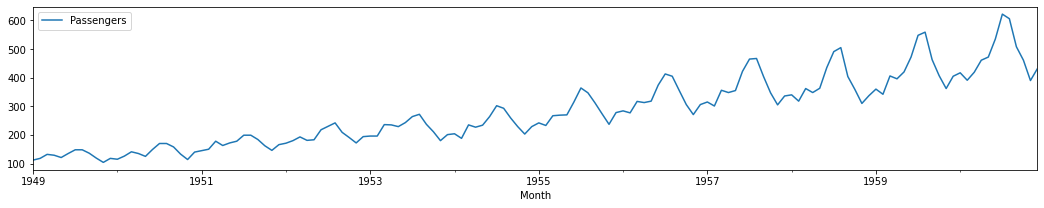

In [ ]:
# plot the dataset
dataframe.plot(figsize = (18,3))

In [ ]:
#calculate first derivative and second derivative
derivative_1 = dataframe.Passengers.diff()
derivative_2 = dataframe.Passengers.diff().diff()
# add them to the dataframe
derivative_1
dataframe['deriv_1'] = derivative_1
dataframe['deriv_2'] = derivative_2
dataframe.fillna(0,inplace=True)


##Vizualize the dataset

In [ ]:
#calculate month of the year
date_list = dataframe.index.values
month_list = []
for date in date_list:
    #print(int(str(date).split('-')[1]))
    month_list.append(int(str(date).split('-')[1]))
    
dataframe['month'] =month_list

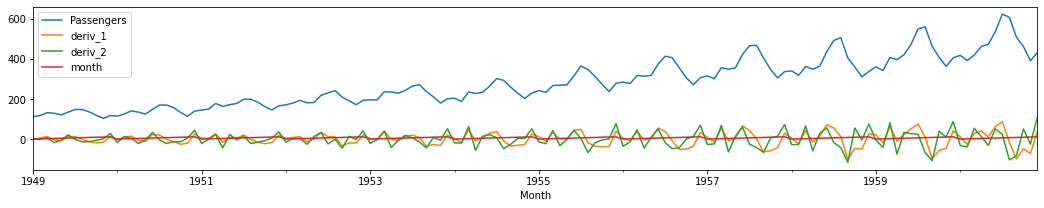

In [ ]:
# plot the dataset
dataframe.plot(figsize = (18,3))

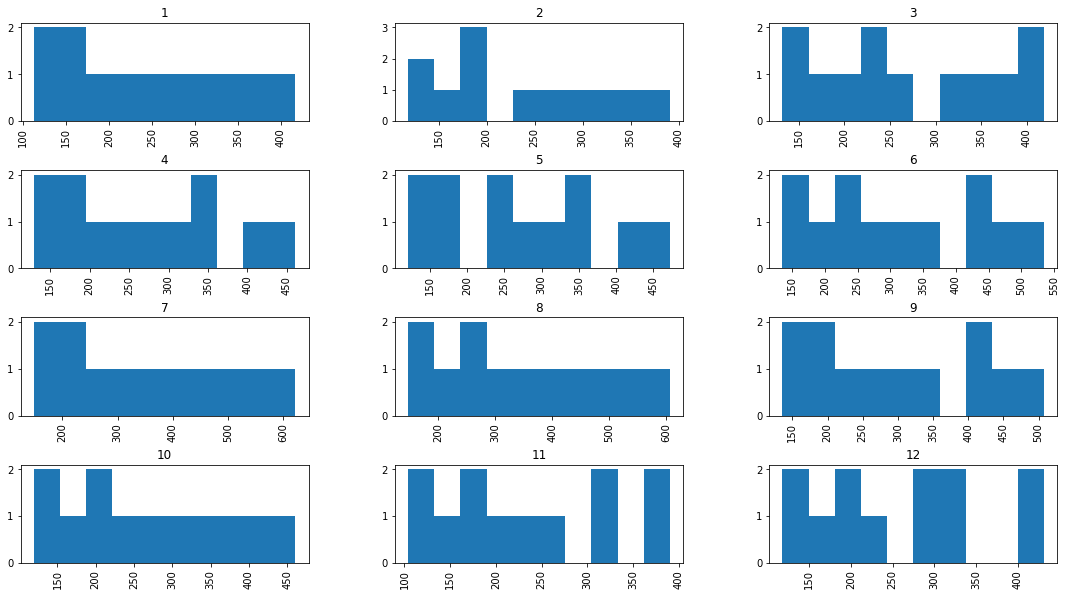

In [ ]:
#plot histogram of Passengers per month"
dataframe.Passengers.hist(by=dataframe['month'],figsize=(18,10))
plt.show()


##Reshape, split and normalize 

In [ ]:
# split  into samples
def split_multivariate_sequence(sequence, n_steps_in, n_steps_out):
	X, y = [], []
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix,0]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# normalize the dataset
X = dataframe.values.astype('float')

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X.shape

(144, 4)

In [ ]:

# split into train and test sets. Use first 70% of the data as trianing and last 30% as test
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
train, test = X[:train_size,:], X[train_size:len(X),:]
train.shape, test.shape

((100, 4), (44, 4))

In [ ]:
#split to train and test 
look_back = 3
n_steps_out = 2
trainX,trainY = split_multivariate_sequence(train,look_back,n_steps_out)
testX,testY = split_multivariate_sequence(test,look_back,n_steps_out)

trainX.shape,trainY.shape ,testX.shape,testY.shape

((96, 3, 4), (96, 2), (40, 3, 4), (40, 2))

##Model definition, training and evaluation

In [ ]:
# define model
from keras.layers import GRU
def LSTM_model_many(imput_shape,num_neurons,n_steps_out):
  _input = Input(shape=input_shape,dtype='float', name='m_input')
  x = GRU(num_neurons, activation='relu')(_input)
  x= RepeatVector(n_steps_out)(x)
  x = GRU(num_neurons, activation='relu', return_sequences=True)(x)
  output =Dense(1)(x)
  my_model = Model(inputs=[_input], outputs=[output])
  optimizer = optimizers.Adam()
  my_model.compile(optimizer=optimizer,loss='mse')
  return my_model
 
num_features = trainX.shape[2]
num_timestamps = trainX.shape[1]
input_shape = (num_timestamps, num_features)
num_neurons=500
model = LSTM_model_many(input_shape,num_neurons,n_steps_out)
model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_input (InputLayer)         [(None, 3, 4)]            0         
_________________________________________________________________
gru_6 (GRU)                  (None, 500)               759000    
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 2, 500)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 2, 500)            1503000   
_________________________________________________________________
dense_15 (Dense)             (None, 2, 1)              501       
Total params: 2,262,501
Trainable params: 2,262,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model
model = LSTM_model_many(input_shape,num_neurons,n_steps_out)
h=model.fit(trainX, trainY, batch_size=10,epochs=100,  validation_data=(testX, testY),verbose=1)

Epoch 1/100
10/10 [==============================] - 1s 68ms/step - loss: 0.0291 - val_loss: 0.1461
Epoch 2/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0136 - val_loss: 0.0359
Epoch 3/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0094 - val_loss: 0.0330
Epoch 4/100
10/10 [==============================] - 0s 42ms/step - loss: 0.0044 - val_loss: 0.0167
Epoch 5/100
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - val_loss: 0.0146
Epoch 6/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0031 - val_loss: 0.0119
Epoch 7/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0024 - val_loss: 0.0115
Epoch 8/100
10/10 [==============================] - 0s 38ms/step - loss: 0.0024 - val_loss: 0.0112
Epoch 9/100
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - val_loss: 0.0105
Epoch 10/100
10/10 [==============================] - 0s 38ms/step - loss: 0.0026 - val_loss: 0.0102

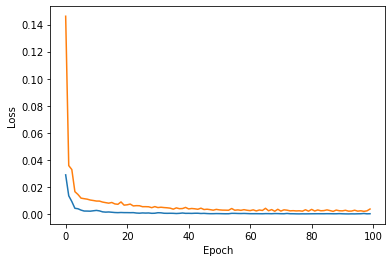

In [ ]:
# plot the learning curves
plt.plot(h.history['loss'],label='train_loss')
plt.plot(h.history['val_loss'],label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

##Vizualize predictions

In [ ]:

# invert predictions from normalized values to real values for 1-step predictions
#the scaler expect the same input_shape as the one uset to fit it (num_instances,num_features)
#however, we need to rescale only the predictions, so we will use a temporary variable (tmp) to match the required shape
tmp = np.column_stack(np.repeat(trainPredict[:,0],4).reshape(len(trainPredict),4).T)

#now we can use the scaler
trainPredict_1 = scaler.inverse_transform(tmp)[:,0]

#the same procedure is required for all variables that we would like to rescale
tmp = np.column_stack(np.repeat(trainY[:,0],4).reshape(len(trainY),4).T)
trainY_1 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(testPredict[:,0],4).reshape(len(testPredict),4).T)
testPredict_1 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(testY[:,0],4).reshape(len(testY),4).T)
testY_1 = scaler.inverse_transform(tmp)[:,0]


# invert predictions from normalized values to real values for 2-step predictions
tmp = np.column_stack(np.repeat(trainPredict[:,1],4).reshape(len(trainPredict),4).T)
trainPredict_2 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(trainY[:,1],4).reshape(len(trainY),4).T)
trainY_2 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(testPredict[:,1],4).reshape(len(testPredict),4).T)
testPredict_2 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(testY[:,1],4).reshape(len(testY),4).T)
testY_2 = scaler.inverse_transform(tmp)[:,0]

In [ ]:
# calculate and print evaluation metrics
trainScore = math.sqrt(mean_squared_error(trainY_1, trainPredict_1))
print('1-step Train RMSE: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_1, testPredict_1))
print('1-step Test RMSE: %.2f RMSE' % (testScore))

print('1-step Train MAE: %.2f MAE' % (mean_absolute_error(trainY_1, trainPredict_1)))
print('1-step Test MAE: %.2f MAE' % (mean_absolute_error(testY_1, testPredict_1)))


trainScore = math.sqrt(mean_squared_error(trainY_2, trainPredict_2))
print('\n2-steps Train RMSE: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_2, testPredict_2))
print('2-steps Test RMSE: %.2f RMSE' % (testScore))

print('2-steps Train MAE: %.2f MAE' % (mean_absolute_error(trainY_2, trainPredict_2)))
print('2-steps Test MAE: %.2f MAE' % (mean_absolute_error(testY_2, testPredict_2)))

1-step Train RMSE: 8.96 RMSE
1-step Test RMSE: 23.78 RMSE
1-step Train MAE: 7.21 MAE
1-step Test MAE: 18.82 MAE

2-steps Train RMSE: 12.34 RMSE
2-steps Test RMSE: 39.01 RMSE
2-steps Train MAE: 10.28 MAE
2-steps Test MAE: 27.21 MAE


In [ ]:
#plot predictions
dataframe['1-step-train_pred']=np.nan
dataframe['2-step-test_pred']=np.nan


In [ ]:

dataframe.iloc[look_back:look_back+len(trainPredict_1),4]= trainPredict_1
dataframe.iloc[-len(testPredict_1):,4]= testPredict_1

dataframe.iloc[look_back:look_back+len(trainPredict_1),5]= trainPredict_2
dataframe.iloc[-len(testPredict_2):,5]= testPredict_2


(100.0, 600.0)

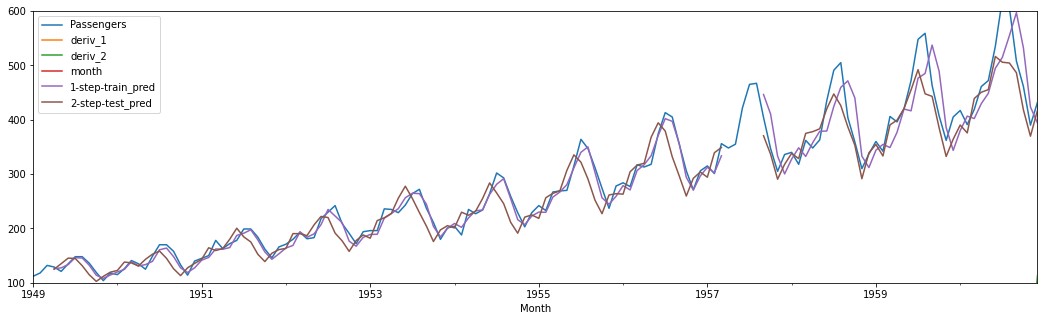

In [ ]:
dataframe.plot(figsize=(18,5))
plt.ylim(100,600)